In [181]:
import numpy as np
from src.cyc_gbm import CycGBM, CycGLM
from src.cyc_gbm.utils import tune_kappa, train_test_split
from src.cyc_gbm.distributions import initiate_distribution
from matplotlib import pyplot as plt
import pandas as pd

In [182]:
n = 10000
p = 3
dist = "beta_prime"
random_seed = 123


def parameter_function(X):
    z0 = 0 + 0.2 * X[:, 1] + 0.3 * (X[:, 2] > 0)
    z1 = 0.5 + 0.04 * X[:, 2] ** 2 + 0.5 * (X[:, 2] > 0)
    return np.stack([z0, z1])


# GBM hyperparameters
kappa_max = 1000
eps_gbm = [0.1, 0.01]
max_depth = 2
min_samples_leaf = 10
n_splits = 2

# GLM hyperparameters
max_iter = 1000
eps_glm = 1e-5
tol = 0.001

## Simulate data

In [183]:
def moving_average(y, window):
    return np.convolve(y, np.ones(window), mode="same") / window


def moving_variance(y, mean, window):
    return moving_average((y - mean) ** 2, window)

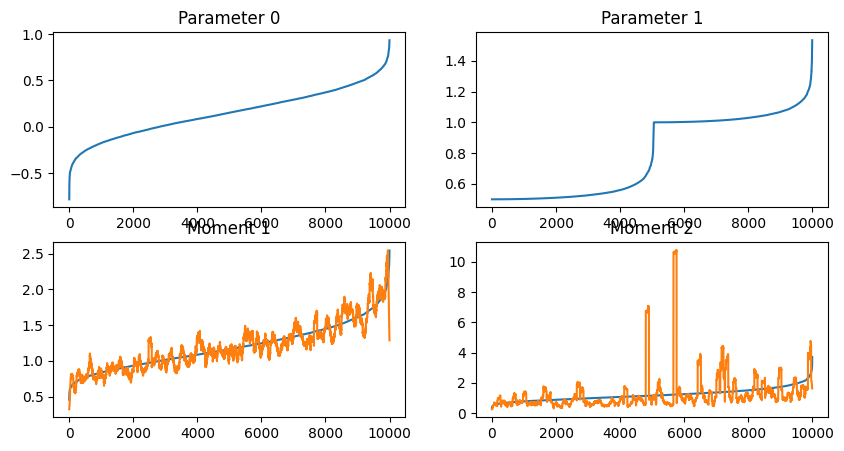

In [184]:
rng = np.random.default_rng(random_seed)
X = np.ones((n, p))
for j in range(1, p):
    X[:, j] = rng.normal(0, 1, n)
z = parameter_function(X)
distribution = initiate_distribution(dist)
y = distribution.simulate(z)

X_train, X_test, y_train, y_test, z_train, z_test, _, _ = train_test_split(
    X=X, y=y, z=z, test_size=0.2, rng=rng
)

fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs = axs.flatten()
for parameter in [0, 1]:
    axs[parameter].set_title(f"Parameter {parameter}")
    sort_order = np.argsort(z[parameter, :])
    axs[parameter].plot(z[parameter, sort_order])

window = n // 100
for moment_order in [1, 2]:
    axs[1 + moment_order].set_title(f"Moment {moment_order}")
    moment = distribution.moment(z=z, k=moment_order)
    sort_order = np.argsort(moment)

    if moment_order == 1:
        empirical_moment = moving_average(y[sort_order], window)
    else:
        mean = distribution.moment(z=z, k=1)
        empirical_moment = moving_variance(y[sort_order], mean[sort_order], window)
    axs[1 + moment_order].plot(moment[sort_order])
    axs[1 + moment_order].plot(empirical_moment)

## Train models

In [185]:
z_hat = {"Train": {"true": z_train}, "Test": {"true": z_test}}

### Intercept model

In [186]:
z0 = distribution.mle(y=y_train)
# Reshape z0 to be the same size as z_train and z_test
z_hat["Train"]["intercept"] = np.tile(z0, (len(y_train), 1)).T
z_hat["Test"]["intercept"] = np.tile(z0, (len(y_test), 1)).T

### GLM

In [198]:
glm = CycGLM(
    dist=dist,
    max_iter=max_iter,
    eps=eps_glm,
    tol=tol,
)
glm.fit(X=X_train, y=y_train)
z_hat["Train"]["glm"] = glm.predict(X=X_train)
z_hat["Test"]["glm"] = glm.predict(X=X_test)

### Univariate GBM

In [199]:
kappa_uni = tune_kappa(
    y=y_train,
    X=X_train,
    kappa_max=[kappa_max, 0],
    eps=eps_gbm,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    n_splits=n_splits,
    rng=rng,
    verbose=1,
    dist=dist,
)["kappa"]

gbm_uni = CycGBM(
    dist=dist,
    kappa=kappa_uni,
    eps=eps_gbm,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
)
gbm_uni.fit(X=X_train, y=y_train)
z_hat["Train"]["gbm_uni"] = gbm_uni.predict(X=X_train)
z_hat["Test"]["gbm_uni"] = gbm_uni.predict(X=X_test)

2023-05-12 10:59:22,319 - src.cyc_gbm.utils - INFO - Starting tuning of kappa with 2-fold cross-validation
INFO:src.cyc_gbm.utils:Starting tuning of kappa with 2-fold cross-validation
2023-05-12 10:59:22,424 - src.cyc_gbm.utils - INFO - Fold 1/2
INFO:src.cyc_gbm.utils:Fold 1/2
2023-05-12 10:59:33,582 - src.cyc_gbm.utils - INFO - Fold 2/2
INFO:src.cyc_gbm.utils:Fold 2/2
2023-05-12 10:59:41,558 - src.cyc_gbm.utils - INFO - Finished tuning of kappa with 2-fold cross-validation
INFO:src.cyc_gbm.utils:Finished tuning of kappa with 2-fold cross-validation
2023-05-12 11:02:07,612 - src.cyc_gbm.utils - INFO - Starting tuning of kappa with 2-fold cross-validation
INFO:src.cyc_gbm.utils:Starting tuning of kappa with 2-fold cross-validation
2023-05-12 11:02:07,618 - src.cyc_gbm.utils - INFO - Fold 1/2
INFO:src.cyc_gbm.utils:Fold 1/2
2023-05-12 11:02:15,459 - src.cyc_gbm.utils - INFO - Fold 2/2
INFO:src.cyc_gbm.utils:Fold 2/2
2023-05-12 11:02:20,345 - src.cyc_gbm.utils - INFO - Finished tuning of 

### Cyclical GBM

In [200]:
kappa_cyc = tune_kappa(
    y=y_train,
    X=X_train,
    kappa_max=kappa_max,
    eps=eps_gbm,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    n_splits=n_splits,
    rng=rng,
    verbose=1,
    dist=dist,
)["kappa"]

gbm_cyc = CycGBM(
    dist=dist,
    kappa=kappa_cyc,
    eps=eps_gbm,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
)
gbm_cyc.fit(X=X_train, y=y_train)
z_hat["Train"]["gbm_cyc"] = gbm_cyc.predict(X=X_train)
z_hat["Test"]["gbm_cyc"] = gbm_cyc.predict(X=X_test)

2023-05-12 10:59:51,890 - src.cyc_gbm.utils - INFO - Starting tuning of kappa with 2-fold cross-validation
INFO:src.cyc_gbm.utils:Starting tuning of kappa with 2-fold cross-validation
2023-05-12 10:59:51,914 - src.cyc_gbm.utils - INFO - Fold 1/2
INFO:src.cyc_gbm.utils:Fold 1/2
2023-05-12 11:00:02,078 - src.cyc_gbm.utils - INFO - Fold 2/2
INFO:src.cyc_gbm.utils:Fold 2/2
2023-05-12 11:00:12,254 - src.cyc_gbm.utils - INFO - Finished tuning of kappa with 2-fold cross-validation
INFO:src.cyc_gbm.utils:Finished tuning of kappa with 2-fold cross-validation
2023-05-12 11:02:28,745 - src.cyc_gbm.utils - INFO - Starting tuning of kappa with 2-fold cross-validation
INFO:src.cyc_gbm.utils:Starting tuning of kappa with 2-fold cross-validation
2023-05-12 11:02:28,749 - src.cyc_gbm.utils - INFO - Fold 1/2
INFO:src.cyc_gbm.utils:Fold 1/2
2023-05-12 11:02:46,300 - src.cyc_gbm.utils - INFO - Fold 2/2
INFO:src.cyc_gbm.utils:Fold 2/2
2023-05-12 11:03:26,541 - src.cyc_gbm.utils - INFO - Finished tuning of 

### Results

In [201]:
kappas = pd.DataFrame(
    columns=[0, 1],
    index=["uni", "cyc"],
)
kappas.loc["uni", :] = kappa_uni
kappas.loc["cyc", :] = kappa_cyc
print("kappas")
print(kappas)
print("\n")

losses = pd.DataFrame(
    columns=["Train", "Test"],
    index=["true", "intercept", "glm", "gbm_uni", "gbm_cyc"],
    dtype=float,
)
for split in ["Train", "Test"]:
    for model in ["intercept", "glm", "gbm_uni", "gbm_cyc", "true"]:
        losses.loc[model, split] = distribution.loss(
            y=y_train if split == "Train" else y_test, z=z_hat[split][model]
        ).mean()
print("losses")
print(losses.round(3))

kappas
      0   1
uni  35   0
cyc  25  16


losses
           Train   Test
true      -0.262 -0.247
intercept -0.163 -0.150
glm       -0.244 -0.221
gbm_uni   -0.257 -0.228
gbm_cyc   -0.263 -0.236
kappas
      0    1
uni  34    0
cyc  35  140


losses
           Train   Test
true      -0.253 -0.261
intercept -0.159 -0.176
glm       -0.235 -0.239
gbm_uni   -0.248 -0.249
gbm_cyc   -0.255 -0.254


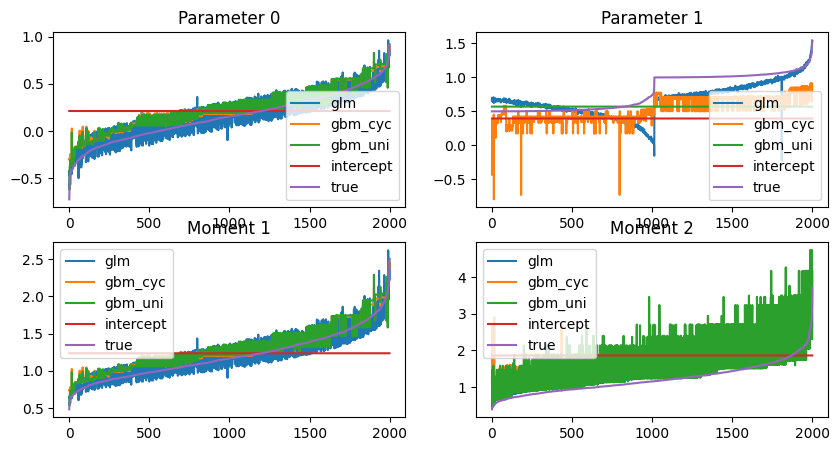

In [204]:
# Compare
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs = axs.flatten()

models = ["glm", "gbm_cyc", "gbm_uni", "intercept", "true"]

for parameter in [0, 1]:
    axs[parameter].set_title(f"Parameter {parameter}")
    sort_order = np.argsort(z_test[parameter, :])
    for model in models:
        axs[parameter].plot(
            z_hat["Test"][model][parameter, sort_order],
            label=model,
        )
    axs[parameter].legend()

for moment_order in [1, 2]:
    axs[1 + moment_order].set_title(f"Moment {moment_order}")
    moment = distribution.moment(z=z_test, k=moment_order)
    sort_order = np.argsort(moment)
    for model in models:
        axs[1 + moment_order].plot(
            distribution.moment(z=z_hat["Test"][model], k=moment_order)[sort_order],
            label=model,
        )
    axs[1 + moment_order].legend()